In [1]:
#### VARIANT FOR MOFA MODEL ESTIMATION Without clinical data

#############################################
# Prerequisites - Load Libraries

In [2]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
   

In [3]:
source('MS4_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [7]:
data_path = '../data/current'

In [8]:
result_path = '../results/current'

In [9]:
name = 'V_FINAL_INTEGRATED'  # name of dataset to load

# Load Data 

## Prepared combined data

In [10]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2024-01-03 14:26:41 CET"


In [12]:
#head(data_long,2)

In [13]:
data_long$X = NULL

In [14]:
length(unique(data_long$sample_id))

[1] 128

## Sample Data

In [15]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [16]:
sample_data$CK_raw = sample_data$CK

In [17]:
sample_data$CK = log2(sample_data$CK+1)

In [18]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [19]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [20]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [21]:
sample_data$sample_id[(sample_data$sample_id == 'm13.2')  & (sample_data$library %in%  c('L6'))] = 'm13.22'

In [22]:
sample_data$sample_id[(sample_data$sample_id == 'm6.4')  & (sample_data$library %in%  c('L10'))] = 'm6.42'

In [23]:
sample_data$sample_id[(sample_data$sample_id == 'm6.1')  & (sample_data$library %in%  c('L3'))] = 'm6.12'

# Train MOFA Model

In [24]:
length(unique(data_long$variable))

[1] 13282

## Remove clinical variables

In [25]:
data_long = data_long[data_long$type != 'clinical_data',]

In [26]:
length(unique(data_long$variable))

[1] 13278

## Prepare data list

In [27]:
length(unique(data_long$sample_id))

[1] 128

In [28]:
final_data_long_backup = data_long

In [29]:
final_data_long = final_data_long_backup

In [30]:
final_data_long$cell_type = NULL

In [31]:
final_data_long$variable_transformed = NULL

In [32]:
final_data_long$type[ final_data_long$type == 'single_cell'] = str_extract(final_data_long$variable[ final_data_long$type == 'single_cell'] , '.*__')

In [33]:
final_data_long$config = NULL

In [34]:
final_data_long$X = NULL

In [35]:
### Filter only samples measured across multiple TPs

In [36]:
samples = unique(final_data_long$sample_id)

In [37]:
unique(final_data_long$type)

[1] "cytokine"                      "neutrophil"                   
 [3] "proteomics"                    "X0_T.cell.CD4__"              
 [5] "X1_T.cell.CD8__"               "X10_B.cell__"                 
 [7] "X11_T.cell.CD4__"              "X12_Monocytes...CD16_FCGR3A__"
 [9] "X13_Dendritic__"               "X2_T.cell.CD4__"              
[11] "X3_NK__"                       "X4_Monocytes...CD14__"        
[13] "X5_T.cell.CD4__"               "X6_Monocytes...CD14__"        
[15] "X7_Monocytes...CD14__"         "X8_B.cell__"                  
[17] "X9_Monocytes...CD16_FCGR3A__"

In [38]:
length(samples)

[1] 128

In [39]:
### Prepare data list for MOFA

In [40]:
data_list = list()

In [41]:
head(final_data_long,2)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
513,k1,BCA1__CXCL13,0.2902127,cytokine
514,k10,BCA1__CXCL13,-0.9726875,cytokine


In [42]:
nrow(final_data_long)

[1] 1699584

In [43]:
data_list= list()

In [44]:
for(i in unique(final_data_long$type)){
    data = final_data_long[final_data_long$type == i, ]
    
    data$type = NULL
    data$cell_type = NULL
    
    data = data %>% dcast(variable ~ sample_id, value  = "value")
    rownames(data) = data$variable
    colnames(data) = str_replace(colnames(data), 'value\\.', '')
    data$variable = NULL
    
    data[setdiff( samples, names(data))] = NA  # use all samples
    
    data = data[,order(colnames(data))]
    data = data[,colnames(data) %in% samples]
    
    data_list[[i]] = as.matrix(data)
    }

In [45]:
dim(data)

[1] 872 128

In [46]:
#str(data_list)

## Create MOFA object

### Create for own data and train

In [47]:
names(data_list) = str_replace_all(names(data_list) , '__|\\.|\\.\\.|\\.\\.\\.', '')

In [48]:
data_list_orig = data_list

In [49]:
## Adjustments for plotting overview

In [50]:
names(data_list) = str_replace(names(data_list), 'X0_TcellCD4', 'CD4+ T cells (Cluster 0)')
names(data_list) = str_replace(names(data_list), 'clinical_data', 'Clinical')
names(data_list) = str_replace(names(data_list), 'X1_TcellCD8', 'CD8+ T cells (Cluster 1)')
names(data_list) = str_replace(names(data_list), 'X10_Bcell', 'B cells (Cluster 10)')
names(data_list) = str_replace(names(data_list), 'X11_TcellCD4', 'CD4+ T cells (Cluster 11)')
names(data_list) = str_replace(names(data_list), 'X12_MonocytesCD16_FCGR3A', 'FCGR3A(high) Monocytes (Cluster 12)')
names(data_list) = str_replace(names(data_list), 'X13_Dendritic', 'Dendritic cells (Cluster 13)')
names(data_list) = str_replace(names(data_list), 'X2_TcellCD4', 'CD4+ T cells (Cluster 2)')
names(data_list) = str_replace(names(data_list), 'X3_NK', 'NK cells (Cluster 3)')
names(data_list) = str_replace(names(data_list), 'X4_MonocytesCD14', 'CD14(high) Monocytes (Cluster 4)')
names(data_list) = str_replace(names(data_list), 'X5_TcellCD4', 'CD4+ T cells (Cluster 5)')
names(data_list) = str_replace(names(data_list), 'X6_MonocytesCD14', 'CD14(high) Monocytes (Cluster 6)')
names(data_list) = str_replace(names(data_list), 'X7_MonocytesCD14', 'CD14(high) Monocytes (Cluster 7)')
names(data_list) = str_replace(names(data_list), 'X8_Bcell','B cells (Cluster 8)')
names(data_list) = str_replace(names(data_list), 'X9_MonocytesCD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')


names(data_list) = str_replace(names(data_list), 'clinical','Clinical')
names(data_list) = str_replace(names(data_list), 'cytokine','Cytokine')
names(data_list) = str_replace(names(data_list), 'neutrophil','Neutrophil')
names(data_list) = str_replace(names(data_list), 'proteomics','Proteomics')

In [51]:
names(data_list)

[1] "Cytokine"                            "Neutrophil"                         
 [3] "Proteomics"                          "CD4+ T cells (Cluster 0)"           
 [5] "CD8+ T cells (Cluster 1)"            "B cells (Cluster 10)"               
 [7] "CD4+ T cells (Cluster 11)"           "FCGR3A(high) Monocytes (Cluster 12)"
 [9] "Dendritic cells (Cluster 13)"        "CD4+ T cells (Cluster 2)"           
[11] "NK cells (Cluster 3)"                "CD14(high) Monocytes (Cluster 4)"   
[13] "CD4+ T cells (Cluster 5)"            "CD14(high) Monocytes (Cluster 6)"   
[15] "CD14(high) Monocytes (Cluster 7)"    "B cells (Cluster 8)"                
[17] "FCGR3A(high) Monocytes (Cluster 9)"

In [52]:
#str(data_list)

In [53]:
MOFAobject = create_mofa(data_list)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [54]:
### Plot Data Overview

In [55]:
options(repr.plot.width=30, repr.plot.height=10)
mofa_overview = plot_data_overview(MOFAobject)

In [56]:
length(unique(data_long$variable))

[1] 13278

In [57]:
# Specific Text Descriptions:
xlabel = xlab('Samples') 
ylabel = ylab('View')

In [58]:
figure_name = "SUPP1_MOFA_Feature_Overview_w_o_clinical"

In [59]:
# Sizes of the plot
width_par = 8.07
height_par =6

In [60]:
mofa_overview = mofa_overview + plot_config +cell_type_colors+
                xlabel + ylabel + theme(axis.text.x = element_blank())

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


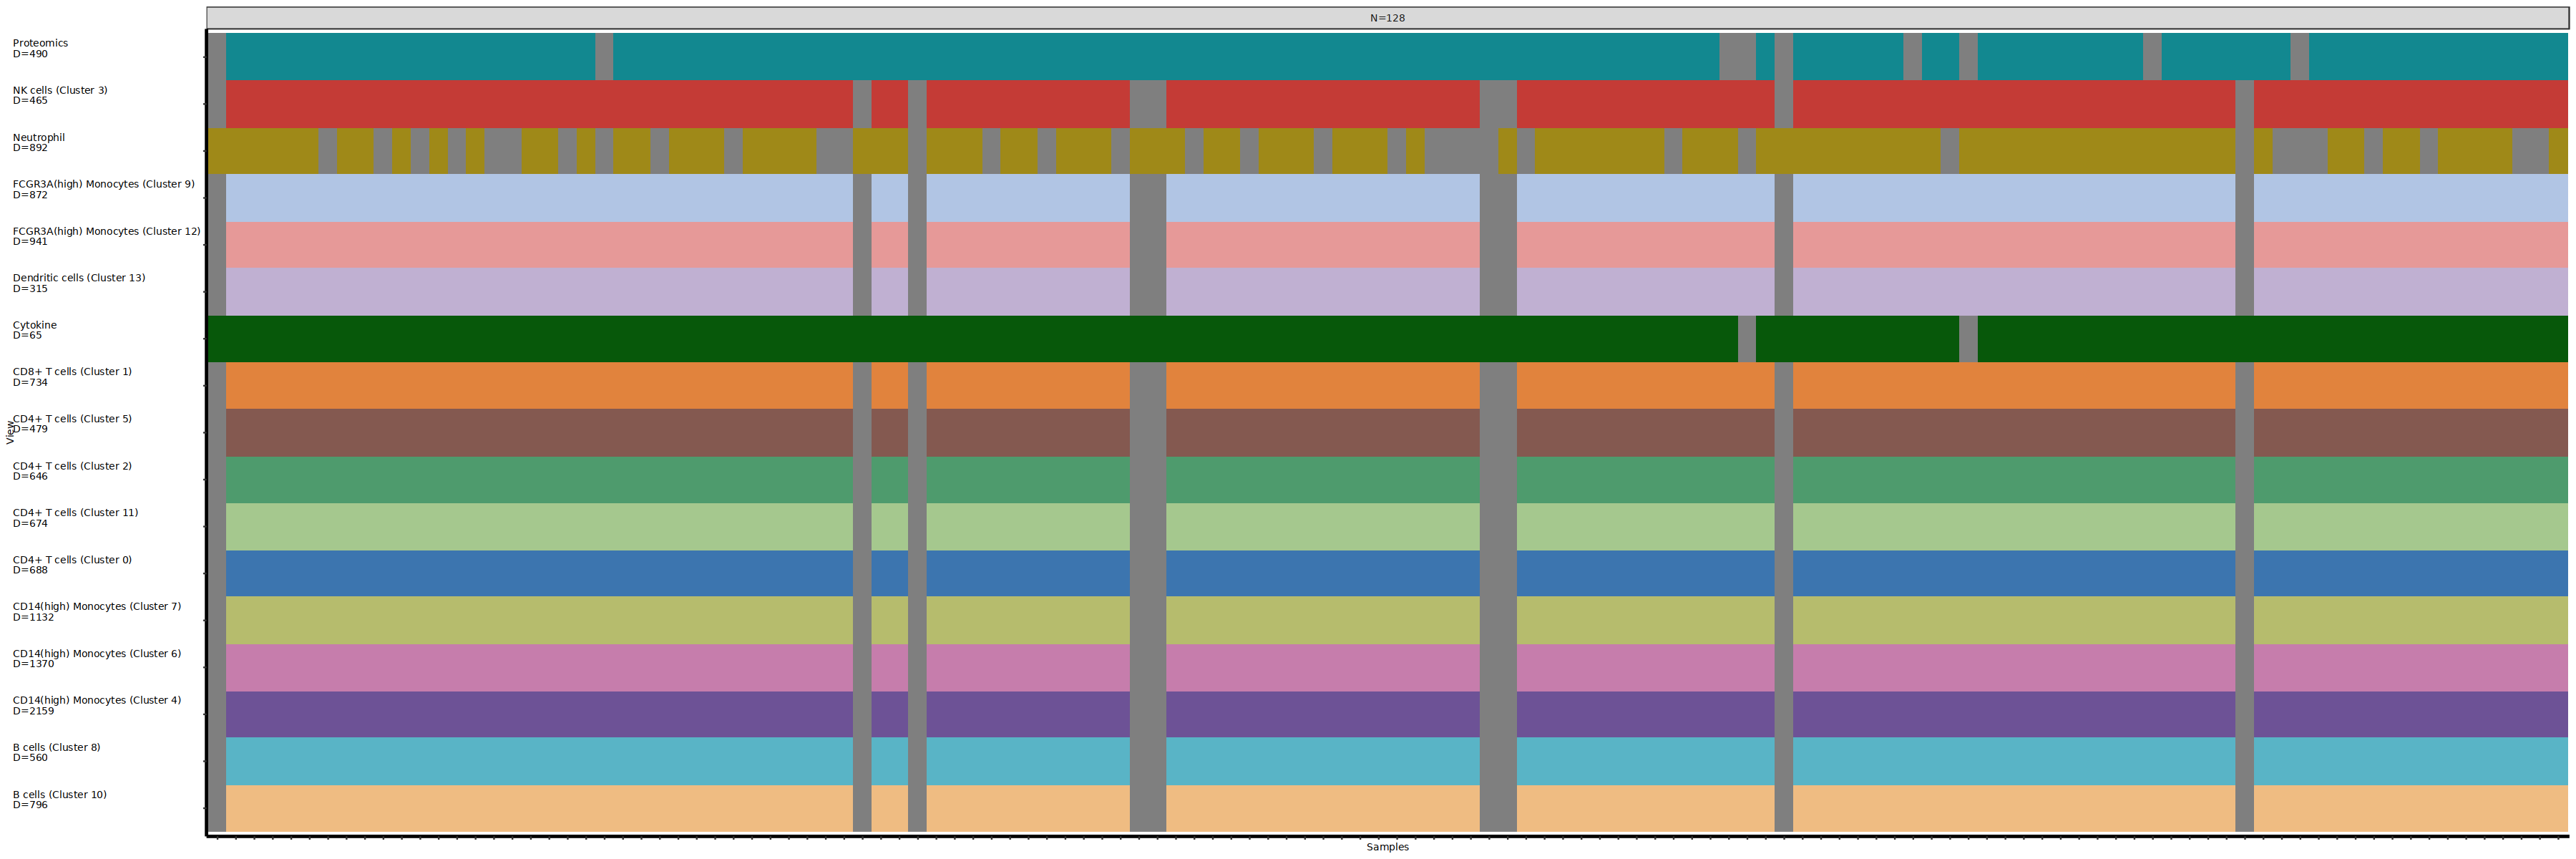

In [61]:
mofa_overview

In [62]:
pdf(paste0('figures/Supplementary_Figures/', figure_name,'_', name,'.pdf'), width =width_par, height = height_par)
print(mofa_overview)
dev.off()

png 
  2

In [63]:
### Use orig MOFA object

In [64]:
MOFAobject = create_mofa(data_list_orig)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




### Set data options

In [65]:
mefisto_opts = get_default_mefisto_options(MOFAobject)

In [66]:
data_opts = get_default_data_options(MOFAobject)

In [67]:
data_opts

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
 [1] "cytokine"                 "neutrophil"              
 [3] "proteomics"               "X0_TcellCD4"             
 [5] "X1_TcellCD8"              "X10_Bcell"               
 [7] "X11_TcellCD4"             "X12_MonocytesCD16_FCGR3A"
 [9] "X13_Dendritic"            "X2_TcellCD4"             
[11] "X3_NK"                    "X4_MonocytesCD14"        
[13] "X5_TcellCD4"              "X6_MonocytesCD14"        
[15] "X7_MonocytesCD14"         "X8_Bcell"                
[17] "X9_MonocytesCD16_FCGR3A" 

$groups
[1] "group1"

In [68]:
data_opts$scale_views = TRUE # decide whether to scale the data

In [69]:
## Define model options

In [70]:
model_opts = get_default_model_options(MOFAobject)
model_opts

$likelihoods
                cytokine               neutrophil               proteomics 
              "gaussian"               "gaussian"               "gaussian" 
             X0_TcellCD4              X1_TcellCD8                X10_Bcell 
              "gaussian"               "gaussian"               "gaussian" 
            X11_TcellCD4 X12_MonocytesCD16_FCGR3A            X13_Dendritic 
              "gaussian"               "gaussian"               "gaussian" 
             X2_TcellCD4                    X3_NK         X4_MonocytesCD14 
              "gaussian"               "gaussian"               "gaussian" 
             X5_TcellCD4         X6_MonocytesCD14         X7_MonocytesCD14 
              "gaussian"               "gaussian"               "gaussian" 
                X8_Bcell  X9_MonocytesCD16_FCGR3A 
              "gaussian"               "gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

In [71]:
model_opts$num_factors = 20 # define number of factors

In [72]:
#model_opts$likelihoods

### Define training options

In [73]:
train_opts  = get_default_training_options(MOFAobject)
train_opts

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] FALSE

$startELBO
[1] 1

$freqELBO
[1] 5

$stochastic
[1] FALSE

$gpu_mode
[1] FALSE

$seed
[1] 42

$outfile
NULL

$weight_views
[1] FALSE

$save_interrupted
[1] FALSE

In [74]:
train_opts$maxiter = 50000

In [75]:
train_opts$verbose = TRUE

In [76]:
train_opts$seed = 42

In [77]:
train_opts$weight_views = FALSE

### Stochastic Options

In [78]:
stoch_options = get_default_stochastic_options(MOFAobject)

In [79]:
stoch_options

$batch_size
[1] 0.5

$learning_rate
[1] 1

$forgetting_rate
[1] 0.5

$start_stochastic
[1] 1

### Build and train the model

In [80]:
MOFAobject = prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  mefisto_options = mefisto_opts,
  training_options = train_opts #,
  #stochastic_options = stoch_options
)

Checking data options...

Checking training options...

Checking model options...



### Save the model

In [81]:
train_opts$weight_views

[1] FALSE

In [82]:
model_name = paste0("MOFA_MODEL_w_o_clinical_", name, '-', train_opts$weight_views,'.hdf5')

In [83]:
model_name


[1] "MOFA_MODEL_w_o_clinical_V_FINAL_INTEGRATED-FALSE.hdf5"

In [84]:
outfile = file.path( paste0(result_path, '/E-Analysis/',  model_name) )

In [89]:
MOFAobject.trained = run_mofa(MOFAobject, outfile, use_basilisk = FALSE)


Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 9, 12, 17 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [90]:
nrow(sample_data)

[1] 149

In [91]:
length(unique(sample_data$sample_id))

[1] 149

In [92]:
model <- load_model(outfile, verbose = TRUE)

Loading data...

Loading expectations for 2 nodes...

Loading model options...

Loading training options and statistics...

Assigning names to the different dimensions...

Re-ordering factors by their variance explained...

Doing quality control...

Checking views names...

Checking groups names...

Checking samples names...

Checking features names...

Checking dimensions...

Checking there are no features with complete missing values...

Checking sample covariates...

Checking expectations...

Checking for intercept factors...

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 9, 12, 17 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”
Checking for highly correlated factors...



In [93]:
length(unique(data_long$variable))

[1] 13278

# Downstream Analysis of generated model

In [94]:
#str(model)

In [95]:
#model = MOFAobject.trained

In [96]:
model@dimensions$D

cytokine               neutrophil               proteomics 
                      65                      892                      490 
             X0_TcellCD4              X1_TcellCD8                X10_Bcell 
                     688                      734                      796 
            X11_TcellCD4 X12_MonocytesCD16_FCGR3A            X13_Dendritic 
                     674                      941                      315 
             X2_TcellCD4                    X3_NK         X4_MonocytesCD14 
                     646                      465                     2159 
             X5_TcellCD4         X6_MonocytesCD14         X7_MonocytesCD14 
                     479                     1370                     1132 
                X8_Bcell  X9_MonocytesCD16_FCGR3A 
                     560                      872

In [97]:
sum(model@dimensions$D)

[1] 13278

## Add metadata to model

In [98]:
head(model@samples_metadata, n=3)

,group,sample
,<fct>,<chr>
1,group1,k1
2,group1,k10
3,group1,k11


In [99]:
nrow(sample_data)

[1] 149

In [100]:
model@samples_metadata = merge(model@samples_metadata, sample_data, by.x = 'sample', by.y = 'sample_id')

In [101]:
nrow(model@samples_metadata)

[1] 128

## Investigate Variance decomposition

In [102]:
# Total variance explained per view and group

In [103]:
model@cache[["variance_explained"]]$r2_total

$group1
                cytokine               neutrophil               proteomics 
                22.94654                 19.16572                 13.74826 
             X0_TcellCD4              X1_TcellCD8                X10_Bcell 
                49.75750                 48.65249                 28.23317 
            X11_TcellCD4 X12_MonocytesCD16_FCGR3A            X13_Dendritic 
                23.65927                 34.12158                 30.09490 
             X2_TcellCD4                    X3_NK         X4_MonocytesCD14 
                45.03925                 42.40353                 50.15944 
             X5_TcellCD4         X6_MonocytesCD14         X7_MonocytesCD14 
                33.05673                 40.66816                 36.00073 
                X8_Bcell  X9_MonocytesCD16_FCGR3A 
                32.88978                 34.23022

In [104]:
rowMeans(model@cache$variance_explained$r2_per_factor[[1]])

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7   Factor8 
5.6614222 4.4303185 3.2453929 2.4616563 1.9425444 1.6971388 1.5105754 1.4950678 
  Factor9  Factor10  Factor11  Factor12  Factor13  Factor14  Factor15  Factor16 
1.3479803 1.2249054 1.1348401 1.1113770 1.0746502 1.0405463 1.0228210 1.0056495 
 Factor17  Factor18  Factor19  Factor20 
0.9598390 0.8842929 0.8787540 0.6741963

In [105]:
#model@cache[["variance_explained"]]

In [106]:
mean(model@cache$variance_explained$r2_total[[1]])

[1] 34.4016

In [107]:
mean(colSums(model@cache$variance_explained$r2_per_factor[[1]]))

[1] 34.80397

In [108]:
str(model@cache$variance_explained)

List of 2
 $ r2_total     :List of 1
  ..$ group1: num [1:17(1d)] 22.9 19.2 13.7 49.8 48.7 ...
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr [1:17] "cytokine" "neutrophil" "proteomics" "X0_TcellCD4" ...
 $ r2_per_factor:List of 1
  ..$ group1: num [1:20, 1:17] 0.212 2.869 1.855 3.066 1.507 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:20] "Factor1" "Factor2" "Factor3" "Factor4" ...
  .. .. ..$ : chr [1:17] "cytokine" "neutrophil" "proteomics" "X0_TcellCD4" ...


In [109]:
model@cache$variance_explained$r2_total

$group1
                cytokine               neutrophil               proteomics 
                22.94654                 19.16572                 13.74826 
             X0_TcellCD4              X1_TcellCD8                X10_Bcell 
                49.75750                 48.65249                 28.23317 
            X11_TcellCD4 X12_MonocytesCD16_FCGR3A            X13_Dendritic 
                23.65927                 34.12158                 30.09490 
             X2_TcellCD4                    X3_NK         X4_MonocytesCD14 
                45.03925                 42.40353                 50.15944 
             X5_TcellCD4         X6_MonocytesCD14         X7_MonocytesCD14 
                33.05673                 40.66816                 36.00073 
                X8_Bcell  X9_MonocytesCD16_FCGR3A 
                32.88978                 34.23022

In [110]:
# Variance explained for every factor in per view and group
model@cache$variance_explained$r2_per_factor[[1]] # group 1, can be summarized per column but not per Factor

,cytokine,neutrophil,proteomics,X0_TcellCD4,X1_TcellCD8,X10_Bcell,X11_TcellCD4,X12_MonocytesCD16_FCGR3A,X13_Dendritic,X2_TcellCD4,X3_NK,X4_MonocytesCD14,X5_TcellCD4,X6_MonocytesCD14,X7_MonocytesCD14,X8_Bcell,X9_MonocytesCD16_FCGR3A
Factor1,0.212337508,0.16055721,0.27161188,12.70568836,12.67096809,4.24244556,3.30591904,4.6571144,5.7111733,10.76763432,8.8619589,8.3574945,5.36413772,5.4173317,4.1795384,4.97233450,4.3859313
Factor2,2.868848385,1.03842878,1.09206409,8.16529325,7.67762048,2.20430416,3.42533553,3.4123326,3.3129352,6.32926145,6.2550288,6.6570454,5.19739268,5.5846717,5.8405450,2.99514063,3.2591659
Factor3,1.855458014,1.02518723,1.69907533,5.75629561,5.24110360,1.70747995,2.24051131,2.6514218,2.6272570,4.48598478,5.5593816,4.8065737,3.73840946,3.4736858,2.7946108,2.95575397,2.5534894
Factor4,3.066370051,0.58067971,2.87497178,3.51910569,3.08601126,1.08648454,1.88525005,1.8618335,1.9733166,3.18525360,3.8275778,2.8190010,3.12481881,2.8382969,2.7905310,1.73416494,1.5944899
Factor5,1.507381127,0.57419733,1.11956105,3.39443781,2.38801984,1.01324048,1.27734107,1.2836089,1.3684367,3.85407492,1.9581077,2.7897713,2.46971794,2.6389627,2.7099782,1.34998572,1.3264318
Factor6,0.995716786,0.18338008,1.40204573,3.85706860,3.42831732,0.71107923,1.38808465,0.8528932,1.0463359,3.51485346,2.3220235,1.8253731,2.70952974,0.9882788,0.8449644,1.93113091,0.8502836
Factor7,0.797458915,0.23930386,0.85011267,0.51153506,0.60394756,0.36850062,0.19305945,1.1183668,1.4198759,1.48218559,0.4858917,6.6761865,0.35581255,5.0333435,4.1224715,0.68409476,0.7376339
Factor8,0.943764605,0.67985678,0.07625452,2.87932265,4.06171317,0.79756587,2.71304390,0.8001291,1.0985333,2.12778229,1.5563684,1.5238925,2.15190856,1.3422513,1.2531434,0.91326369,0.4973592
Factor9,0.919192942,0.48242032,0.08542771,0.06890216,0.36460512,8.29998260,0.54002179,1.0268669,1.5599337,0.02937140,0.3802624,0.7275675,0.02730339,1.4625110,1.0757183,4.35280640,1.5127706
Factor10,0.613455379,0.54383808,0.71049557,1.64403651,1.47478601,0.78932011,0.95171731,0.9359908,0.7060371,1.68242770,1.7878132,2.6638877,1.41747116,1.0405443,1.5587750,1.32157703,0.9812183


In [111]:
### Save the variance decompositoin (Potentially as supplementary Table)

In [112]:
variant = '_'

In [113]:
write.csv(model@cache$variance_explained$r2_per_factor[[1]], paste0(result_path, '/E-Analysis/MOFA_Variance_Decomposition_w_o_clinical',name, variant, train_opts$weight_views, '.csv'))

# Extract and prepare data for plots

## Adjust sample data columns

In [114]:
sample_data$class = sample_data$group

In [115]:
sample_data$measurement2 = sample_data$measurement

In [116]:
sample_data$measurement2[sample_data$class %in% c('no_ccs', 'ccs')] = paste0(sample_data$measurement[sample_data$class %in% c('no_ccs', 'ccs')] , '_', sample_data$class[sample_data$class %in% c('no_ccs', 'ccs')])

In [117]:
sample_data$measurement_class =  paste0(sample_data$measurement , '_', sample_data$classification)

In [118]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [119]:
unique(sample_data$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP2_acs_subacute"              "TP3_acs_subacute"             
 [7] "TP4_acs_subacute"              "TP1_acs_w_infection"          
 [9] "TP2_acs_w_infection"           "TP3_acs_w_infection"          
[11] "TP4_acs_w_infection"           "TP1_acs_w_o_infection"        
[13] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[15] "TP4_acs_w_o_infection"

In [120]:
# Summarize good and intermediate outcome    
sample_data$delta_ef_value_class_summarized = sample_data$delta_ef_value_class
sample_data$delta_ef_value_class_summarized[sample_data$delta_ef_value_class %in% c('intermediate')] = 'good'

In [121]:
unique(sample_data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [122]:
## Concatenate outcome with class

In [123]:
sample_data$tp_outcome = paste0(sample_data$measurement, '_', sample_data$delta_ef_value_class_summarized)

In [124]:
unique(sample_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP2_NA"   "TP3_NA"   "TP4_NA"   "TP1_bad" 
 [7] "TP2_bad"  "TP3_bad"  "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

## Extract data (for potential supplementary tables)

In [125]:
### Visualization of single factors

In [126]:
#### Extract factors and evaluate based on sample-data

In [127]:
factors = get_factors(model, factors = "all")

In [128]:
factors = factors$group1

In [129]:
head(factors,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20
k1,0.2399255,-0.05739971,1.4907896,-0.32665242,1.267384,-0.76449296,-0.2062638,-0.4015635,0.13934268,-0.5942366,-0.05194047,1.3987023,-0.2781827,0.3304071,0.1524369,0.343907604,0.59804301,-0.63067345,-0.48486844,-0.20108153
k10,0.9120340,-0.73742041,0.3457404,-0.08340577,0.397841,-0.03302189,-1.1732596,0.6276986,-0.05103549,-0.3492411,-0.01582432,-0.1025336,0.2056910,0.1377031,0.1219240,-0.007729483,-0.04886579,0.07816087,0.09603544,-0.03821721


In [130]:
factors = as.data.frame(factors)

In [131]:
factors$sample_id = rownames(factors)

In [132]:
name

[1] "V_FINAL_INTEGRATED"

In [133]:
### Save Factor Data - potentially as supplementary Table

In [134]:
write.csv(factors, paste0(result_path, '/E-Analysis/Factor_Data_w_o_clinical' , name,'_', train_opts$weight_views,  '.csv'), row.names = FALSE)

In [135]:
weights = get_weights(model, views = "all", factors = "all")

In [136]:
head(data_list[[1]],2)

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
BCA1__CXCL13,0.29021267,-0.9726875,0.3108620,-0.1087689,0.2289630,1.8592471,-1.9841054,1.004868,-0.2492730,-0.4818377,⋯,1.108336,0.3525718,0.9414844,0.1087689,-0.3525718,-1.413597,-0.643831,1.3619035,1.268206,0.5959912
CTACK__CCL27,-0.08893463,-0.3316448,0.7185131,0.1485740,-0.4818377,-0.9111721,-0.8529252,-1.530131,0.7443035,-0.3108620,⋯,-1.984105,-1.5971323,-1.4693707,-0.7185131,-0.8816747,-0.643831,-0.668308,0.5041254,0.128646,0.5959912


In [137]:
head(get_data(model)[[1]][[1]],2)

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
BCA1__CXCL13,0.31127582,-1.0432838,0.3334239,-0.1166632,0.2455808,1.9941886,-2.1281091,1.077799,-0.267365,-0.5168089,⋯,1.188778,0.3781609,1.009816,0.1166631,-0.3781611,-1.5161938,-0.6905594,1.4607485,1.3602505,0.6392473
CTACK__CCL27,-0.09538939,-0.3557151,0.7706618,0.1593573,-0.5168088,-0.9773037,-0.9148293,-1.641186,0.798324,-0.3334240,⋯,-2.128109,-1.7130499,-1.576016,-0.7706618,-0.9456654,-0.6905593,-0.7168129,0.5407142,0.1379829,0.6392474


In [138]:
weight_data = data.frame()

In [139]:
names(weights)

[1] "cytokine"                 "neutrophil"              
 [3] "proteomics"               "X0_TcellCD4"             
 [5] "X1_TcellCD8"              "X10_Bcell"               
 [7] "X11_TcellCD4"             "X12_MonocytesCD16_FCGR3A"
 [9] "X13_Dendritic"            "X2_TcellCD4"             
[11] "X3_NK"                    "X4_MonocytesCD14"        
[13] "X5_TcellCD4"              "X6_MonocytesCD14"        
[15] "X7_MonocytesCD14"         "X8_Bcell"                
[17] "X9_MonocytesCD16_FCGR3A"

In [140]:
for (i in names(weights)){
    data = data.frame(weights[[i]])
    data$type = i
    weight_data = rbind(weight_data,data)
    }

In [141]:
weight_data$variable_name = rownames(weight_data)

In [142]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
BCA1__CXCL13,0.007872607,0.01834307,-0.01672033,-0.3090944808,-0.04257815,-0.04290609,0.02036166,-0.02911915,-0.09958332,-0.15661780,⋯,0.50467277,0.04324221,0.6661882,-0.041123314,-0.20769065,0.1357149,-0.05794182,-0.009094946,cytokine,BCA1__CXCL13
CTACK__CCL27,0.016026314,-0.17902272,0.02978679,-0.0001092699,0.08309032,-0.05366863,0.03047595,-0.03859843,-0.26235709,-0.02720419,⋯,0.09532608,-0.05772901,0.0201950,-0.004542783,0.03819823,0.2465448,-0.03517982,0.198791111,cytokine,CTACK__CCL27


In [143]:
name

[1] "V_FINAL_INTEGRATED"

In [144]:
#### Save weight data potentially as supplementary table

In [145]:
write.csv(weight_data, paste0(result_path, '/E-Analysis/Weight_Data_w_o_clinical' , name, '_', train_opts$weight_views, '.csv'), row.names = FALSE)

## Merge factors and sample data

In [146]:
head(factors,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,sample_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
k1,0.2399255,-0.05739971,1.4907896,-0.32665242,1.267384,-0.76449296,-0.2062638,-0.4015635,0.13934268,-0.5942366,⋯,1.3987023,-0.2781827,0.3304071,0.1524369,0.343907604,0.59804301,-0.63067345,-0.48486844,-0.20108153,k1
k10,0.9120340,-0.73742041,0.3457404,-0.08340577,0.397841,-0.03302189,-1.1732596,0.6276986,-0.05103549,-0.3492411,⋯,-0.1025336,0.2056910,0.1377031,0.1219240,-0.007729483,-0.04886579,0.07816087,0.09603544,-0.03821721,k10


In [147]:
nrow(factors)

[1] 128

In [148]:
colnames(sample_data)

[1] "X.1"                             "sample_id"                      
 [3] "sample"                          "id"                             
 [5] "measurement"                     "library"                        
 [7] "id.y"                            "name"                           
 [9] "read"                            "pattern"                        
[11] "sequence"                        "feature_type"                   
[13] "X"                               "in_sample"                      
[15] "measurement_tp"                  "sc_rna_seq_data"                
[17] "age"                             "sex"                            
[19] "classification"                  "group"                          
[21] "meta_data"                       "delta_ef_value_group"           
[23] "delta_ef_value"                  "delta_ef_value_class"           
[25] "ef_classification_data"          "CK"                             
[27] "CK_MB"                           "Troponin"                       
[29] "CRP"                             "clinical_data"                  
[31] "CK_raw"                          "class"                          
[33] "measurement2"                    "measurement_class"              
[35] "delta_ef_value_class_summarized" "tp_outcome"

In [149]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [150]:
nrow(sample_data)

[1] 149

In [151]:
length(unique(sample_data$sample_id))

[1] 149

In [152]:
factors_merge = data.frame(factors)

In [153]:
factors_merge$sample_id = rownames(factors_merge)

In [154]:
merged_data = merge(factors_merge, sample_data, by.x = 'sample_id', by.y = 'sample_id')

In [155]:
#summary(merged_data)

In [156]:
length(unique(merged_data$sample_id))

[1] 128

In [157]:
nrow(merged_data)

[1] 128

In [158]:
### Prepare long format and add necessary sample columns

In [159]:
merged_data$delta_ef_value = as.character(merged_data$delta_ef_value)

In [160]:
merged_data_long = melt(merged_data)

Using sample_id, sample, measurement, library, id.y, name, read, pattern, sequence, feature_type, X, measurement_tp, sex, classification, group, delta_ef_value_group, delta_ef_value, delta_ef_value_class, class, measurement2, measurement_class, delta_ef_value_class_summarized, tp_outcome as id variables



In [161]:
merged_data_long = merged_data_long[!is.na(str_extract(merged_data_long$variable, 'Factor')),]

In [162]:
colnames(merged_data_long)

[1] "sample_id"                       "sample"                         
 [3] "measurement"                     "library"                        
 [5] "id.y"                            "name"                           
 [7] "read"                            "pattern"                        
 [9] "sequence"                        "feature_type"                   
[11] "X"                               "measurement_tp"                 
[13] "sex"                             "classification"                 
[15] "group"                           "delta_ef_value_group"           
[17] "delta_ef_value"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "variable"                       
[25] "value"

In [163]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [164]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [165]:
unique(merged_data_long$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP1_acs_w_infection"           "TP2_acs_w_infection"          
 [7] "TP3_acs_w_infection"           "TP1_acs_w_o_infection"        
 [9] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[11] "TP4_acs_w_o_infection"         "TP4_acs_w_infection"          
[13] "TP2_acs_subacute"              "TP3_acs_subacute"             
[15] "TP4_acs_subacute"

In [166]:
merged_data_long$class_measurement = merged_data_long$group
merged_data_long$class_measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] =merged_data_long$measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] 

In [167]:
unique(merged_data_long$class_measurement)

[1] "no_ccs" "ccs"    "TP1"    "TP2"    "TP3"    "TP4"

## Extract explained variance for plotting

In [168]:
data = model@cache$variance_explained$r2_per_factor[[1]]

In [169]:
total_variance = data.frame( view = rownames(model@cache[["variance_explained"]]$r2_total$group1,2),
                             total_variance = model@cache[["variance_explained"]]$r2_total$group1)

In [170]:
total_variance_factor = data.frame(factor = names(rowMeans(model@cache$variance_explained$r2_per_factor[[1]])),
                                   mean_variance = rowMeans(model@cache$variance_explained$r2_per_factor[[1]]))

In [171]:
head(total_variance_factor,2)

,factor,mean_variance
,<chr>,<dbl>
Factor1,Factor1,5.661422
Factor2,Factor2,4.430318


In [172]:
str(model@cache$variance_explained)

List of 2
 $ r2_total     :List of 1
  ..$ group1: num [1:17(1d)] 22.9 19.2 13.7 49.8 48.7 ...
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr [1:17] "cytokine" "neutrophil" "proteomics" "X0_TcellCD4" ...
 $ r2_per_factor:List of 1
  ..$ group1: num [1:20, 1:17] 0.212 2.869 1.855 3.066 1.507 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:20] "Factor1" "Factor2" "Factor3" "Factor4" ...
  .. .. ..$ : chr [1:17] "cytokine" "neutrophil" "proteomics" "X0_TcellCD4" ...


In [173]:
head(total_variance,2)

,view,total_variance
,<chr>,<dbl>
cytokine,cytokine,22.94654
neutrophil,neutrophil,19.16572


In [174]:
data = melt(data)

In [175]:
data = merge(data, total_variance, by.x = 'Var2', by.y = 'view')

In [176]:
head(data,2)

,Var2,Var1,value,total_variance
,<fct>,<fct>,<dbl>,<dbl>
1,cytokine,Factor1,0.2123375,22.94654
2,cytokine,Factor2,2.8688484,22.94654


In [177]:
#data = data[data$Var1 %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'),]

In [178]:
data$Var2 = str_replace(data$Var2, 'X0_TcellCD4', 'CD4+ T cells (Cluster 0)')
data$Var2 = str_replace(data$Var2, 'clinical_data', 'Clinical')
data$Var2 = str_replace(data$Var2, 'X1_TcellCD8', 'CD8+ T cells (Cluster 1)')
data$Var2 = str_replace(data$Var2, 'X10_Bcell', 'B cells (Cluster 10)')
data$Var2 = str_replace(data$Var2, 'X11_TcellCD4', 'CD4+ T cells (Cluster 11)')
data$Var2 = str_replace(data$Var2, 'X12_MonocytesCD16_FCGR3A', 'FCGR3A(high) Monocytes (Cluster 12)')
data$Var2 = str_replace(data$Var2, 'X13_Dendritic', 'Dendritic cells (Cluster 13)')
data$Var2 = str_replace(data$Var2, 'X2_TcellCD4', 'CD4+ T cells (Cluster 2)')
data$Var2 = str_replace(data$Var2, 'X3_NK', 'NK cells (Cluster 3)')
data$Var2 = str_replace(data$Var2, 'X4_MonocytesCD14', 'CD14(high) Monocytes (Cluster 4)')
data$Var2 = str_replace(data$Var2, 'X5_TcellCD4', 'CD4+ T cells (Cluster 5)')
data$Var2 = str_replace(data$Var2, 'X6_MonocytesCD14', 'CD14(high) Monocytes (Cluster 6)')
data$Var2 = str_replace(data$Var2, 'X7_MonocytesCD14', 'CD14(high) Monocytes (Cluster 7)')
data$Var2 = str_replace(data$Var2, 'X8_Bcell','B cells (Cluster 8)')
data$Var2 = str_replace(data$Var2, 'X9_MonocytesCD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')


data$Var2 = str_replace(data$Var2, 'clinical','Clinical')
data$Var2 = str_replace(data$Var2, 'cytokine','Cytokine')
data$Var2 = str_replace(data$Var2, 'neutrophil','Neutrophil')
data$Var2 = str_replace(data$Var2, 'proteomics','Proteomics')

In [179]:
unique(data$Var2)

[1] "Cytokine"                            "Neutrophil"                         
 [3] "Proteomics"                          "CD4+ T cells (Cluster 0)"           
 [5] "CD8+ T cells (Cluster 1)"            "B cells (Cluster 10)"               
 [7] "CD4+ T cells (Cluster 11)"           "FCGR3A(high) Monocytes (Cluster 12)"
 [9] "Dendritic cells (Cluster 13)"        "CD4+ T cells (Cluster 2)"           
[11] "NK cells (Cluster 3)"                "CD14(high) Monocytes (Cluster 4)"   
[13] "CD4+ T cells (Cluster 5)"            "CD14(high) Monocytes (Cluster 6)"   
[15] "CD14(high) Monocytes (Cluster 7)"    "B cells (Cluster 8)"                
[17] "FCGR3A(high) Monocytes (Cluster 9)"

In [180]:
data$Var2 = as.character(data$Var2)

## Prepare weight data

In [181]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
BCA1__CXCL13,0.007872607,0.01834307,-0.01672033,-0.3090944808,-0.04257815,-0.04290609,0.02036166,-0.02911915,-0.09958332,-0.15661780,⋯,0.50467277,0.04324221,0.6661882,-0.041123314,-0.20769065,0.1357149,-0.05794182,-0.009094946,cytokine,BCA1__CXCL13
CTACK__CCL27,0.016026314,-0.17902272,0.02978679,-0.0001092699,0.08309032,-0.05366863,0.03047595,-0.03859843,-0.26235709,-0.02720419,⋯,0.09532608,-0.05772901,0.0201950,-0.004542783,0.03819823,0.2465448,-0.03517982,0.198791111,cytokine,CTACK__CCL27


In [182]:
weight_data$gene = weight_data$variable_name

In [183]:
#weight_data$gene[weight_data$type == 'cytokine'] = str_extract(weight_data$variable_name[weight_data$type == 'cytokine'] , '__.*')

In [184]:
#weight_data$gene[weight_data$type == 'proteomics'] = str_extract(weight_data$variable_name[weight_data$type == 'proteomics'] , '.*_')

In [185]:
unique(weight_data$type)

[1] "cytokine"                 "neutrophil"              
 [3] "proteomics"               "X0_TcellCD4"             
 [5] "X1_TcellCD8"              "X10_Bcell"               
 [7] "X11_TcellCD4"             "X12_MonocytesCD16_FCGR3A"
 [9] "X13_Dendritic"            "X2_TcellCD4"             
[11] "X3_NK"                    "X4_MonocytesCD14"        
[13] "X5_TcellCD4"              "X6_MonocytesCD14"        
[15] "X7_MonocytesCD14"         "X8_Bcell"                
[17] "X9_MonocytesCD16_FCGR3A"

In [186]:
weight_data$gene = str_replace(weight_data$variable_name, '.*__', '')

In [187]:
weight_data$view = weight_data$type

In [188]:
weight_data$view[!weight_data$type %in% c('cytokine','neutrophil','proteomics', 'clinical_data')] = str_replace(weight_data$variable_name[!weight_data$type %in% c('cytokine','neutrophil','proteomics', 'clinical_data')], '__.*', '')

In [189]:
unique(weight_data$view)

[1] "cytokine"                    "neutrophil"                 
 [3] "proteomics"                  "X0_T.cell.CD4"              
 [5] "X1_T.cell.CD8"               "X10_B.cell"                 
 [7] "X11_T.cell.CD4"              "X12_Monocytes...CD16_FCGR3A"
 [9] "X13_Dendritic"               "X2_T.cell.CD4"              
[11] "X3_NK"                       "X4_Monocytes...CD14"        
[13] "X5_T.cell.CD4"               "X6_Monocytes...CD14"        
[15] "X7_Monocytes...CD14"         "X8_B.cell"                  
[17] "X9_Monocytes...CD16_FCGR3A"

In [190]:
weight_data$view = str_replace(weight_data$view, make.names('X0_T.cell.CD4'), 'CD4+ T cells (Cluster 0)')
weight_data$view = str_replace(weight_data$view, 'clinical_data', 'Clinical')
weight_data$view = str_replace(weight_data$view, 'X1_T.cell.CD8', 'CD8+ T cells (Cluster 1)')
weight_data$view = str_replace(weight_data$view, 'X10_B.cell', 'B cells (Cluster 10)')
weight_data$view = str_replace(weight_data$view, 'X11_T.cell.CD4', 'CD4+ T cells (Cluster 11)')
weight_data$view = str_replace(weight_data$view, 'X12_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 12)')
weight_data$view = str_replace(weight_data$view, 'X13_Dendritic',  'Dendritic cells (Cluster 13)')
weight_data$view = str_replace(weight_data$view, 'X2_T.cell.CD4', 'CD4+ T cells (Cluster 2)')
weight_data$view = str_replace(weight_data$view, 'X3_NK', 'NK cells (Cluster 3)')
weight_data$view = str_replace(weight_data$view, 'X4_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 4)')
weight_data$view = str_replace(weight_data$view, 'X5_T.cell.CD4', 'CD4+ T cells (Cluster 5)')
weight_data$view = str_replace(weight_data$view, 'X6_Monocytes...CD14','CD14(high) Monocytes (Cluster 6)')
weight_data$view = str_replace(weight_data$view, 'X7_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 7)')
weight_data$view = str_replace(weight_data$view, 'X8_B.cell','B cells (Cluster 8)')
weight_data$view = str_replace(weight_data$view, 'X9_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')

weight_data$view  = str_replace(weight_data$view , 'clinical','Clinical')
weight_data$view  = str_replace(weight_data$view , 'cytokine','Cytokine')
weight_data$view  = str_replace(weight_data$view , 'neutrophil','Neutrophil')
weight_data$view  = str_replace(weight_data$view , 'proteomics','Proteomics')

In [191]:
unique(weight_data$view)

[1] "Cytokine"                            "Neutrophil"                         
 [3] "Proteomics"                          "CD4+ T cells (Cluster 0)"           
 [5] "CD8+ T cells (Cluster 1)"            "B cells (Cluster 10)"               
 [7] "CD4+ T cells (Cluster 11)"           "FCGR3A(high) Monocytes (Cluster 12)"
 [9] "Dendritic cells (Cluster 13)"        "CD4+ T cells (Cluster 2)"           
[11] "NK cells (Cluster 3)"                "CD14(high) Monocytes (Cluster 4)"   
[13] "CD4+ T cells (Cluster 5)"            "CD14(high) Monocytes (Cluster 6)"   
[15] "CD14(high) Monocytes (Cluster 7)"    "B cells (Cluster 8)"                
[17] "FCGR3A(high) Monocytes (Cluster 9)"

In [192]:
#weight_data$gene = str_replace(weight_data$gene, '__', '')

In [193]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name,gene,view
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
BCA1__CXCL13,0.007872607,0.01834307,-0.01672033,-0.3090944808,-0.04257815,-0.04290609,0.02036166,-0.02911915,-0.09958332,-0.15661780,⋯,0.6661882,-0.041123314,-0.20769065,0.1357149,-0.05794182,-0.009094946,cytokine,BCA1__CXCL13,CXCL13,Cytokine
CTACK__CCL27,0.016026314,-0.17902272,0.02978679,-0.0001092699,0.08309032,-0.05366863,0.03047595,-0.03859843,-0.26235709,-0.02720419,⋯,0.0201950,-0.004542783,0.03819823,0.2465448,-0.03517982,0.198791111,cytokine,CTACK__CCL27,CCL27,Cytokine


In [194]:
feature_weights_long = melt(weight_data)

Using type, variable_name, gene, view as id variables



In [195]:
head(feature_weights_long,2)

,type,variable_name,gene,view,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,cytokine,BCA1__CXCL13,CXCL13,Cytokine,Factor1,0.007872607
2,cytokine,CTACK__CCL27,CCL27,Cytokine,Factor1,0.016026314


In [196]:
factor_data = melt(factors)

Using sample_id as id variables



In [197]:
head(factor_data,2)

,sample_id,variable,value
,<chr>,<fct>,<dbl>
1,k1,Factor1,0.2399255
2,k10,Factor1,0.9120340


In [198]:
colnames(factor_data) = c('sample_id', 'variable', 'value')

## Get top features per factor and amounts for diff thresholds

In [199]:
top_variable_fraction_list  = c(0.0005 ,0.001, 0.0025, 0.005, 0.025, 0.05, 0.1,0.5)

In [200]:
geneset_oi_amounts = data.frame()

In [201]:
geneset_oi_per_fraction = data.frame()

In [202]:
head(feature_weights_long,2)

,type,variable_name,gene,view,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,cytokine,BCA1__CXCL13,CXCL13,Cytokine,Factor1,0.007872607
2,cytokine,CTACK__CCL27,CCL27,Cytokine,Factor1,0.016026314


In [203]:
dimensions = unique(feature_weights_long[,c('view', 'variable')])

In [204]:
head(dimensions)

,view,variable
,<chr>,<fct>
1,Cytokine,Factor1
66,Neutrophil,Factor1
958,Proteomics,Factor1
1448,CD4+ T cells (Cluster 0),Factor1
2136,CD8+ T cells (Cluster 1),Factor1
2870,B cells (Cluster 10),Factor1


In [205]:
for(i in top_variable_fraction_list){
    ## Define amont of top genes per fraction 
    geneset_oi_pos_per_factor_analyze = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(i)
    geneset_oi_pos_per_factor_analyze$direction = 'positive'
    
    geneset_oi_neg_per_factor_analyze = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-i)
    geneset_oi_neg_per_factor_analyze$direction = 'negative'
    
    geneset_oi_analyze = rbind(geneset_oi_pos_per_factor_analyze, geneset_oi_neg_per_factor_analyze)
    geneset_oi_analyze$fraction = i
    
    geneset_oi_per_fraction = rbind(geneset_oi_per_fraction,geneset_oi_analyze)
    
    amount_geneset_oi_type = geneset_oi_analyze %>% group_by(type, view, variable) %>% count()
    amount_geneset_oi_type = merge(dimensions, amount_geneset_oi_type, all.x = TRUE)
    amount_geneset_oi_type$fraction = i
    
    geneset_oi_amounts = rbind(geneset_oi_amounts, amount_geneset_oi_type)
    }

Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value


In [206]:
features_per_type = feature_weights_long %>% group_by(type, view, variable) %>% count()
colnames(features_per_type) = c('type', 'view', 'variable', 'amount_features')

In [207]:
head(features_per_type,2)

type,view,variable,amount_features
<chr>,<chr>,<fct>,<int>
X0_TcellCD4,CD4+ T cells (Cluster 0),Factor1,688
X0_TcellCD4,CD4+ T cells (Cluster 0),Factor2,688


In [208]:
geneset_oi_amounts = merge(  geneset_oi_amounts,features_per_type, all.x = TRUE)
geneset_oi_amounts$percentage = geneset_oi_amounts$n / geneset_oi_amounts$amount_features

In [209]:
head(geneset_oi_per_fraction,2)

type,variable_name,gene,view,variable,value,direction,fraction
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>
X0_TcellCD4,X0_T.cell.CD4__PFN1,PFN1,CD4+ T cells (Cluster 0),Factor1,0.5382836,positive,5e-04
X0_TcellCD4,X0_T.cell.CD4__CYBA,CYBA,CD4+ T cells (Cluster 0),Factor1,0.5225588,positive,5e-04


In [210]:
head(geneset_oi_amounts,2)

,view,variable,type,n,fraction,amount_features,percentage
,<chr>,<fct>,<chr>,<int>,<dbl>,<int>,<dbl>
1,B cells (Cluster 10),Factor1,X10_Bcell,24,0.05,796,0.03015075
2,B cells (Cluster 10),Factor1,X10_Bcell,796,0.50,796,1.00000000


In [211]:
geneset_oi_amounts[is.na(geneset_oi_amounts)] = 0

## Prepare heatmap data (based on transformed expression values)

In [212]:
### Subset on a selected fraction/ set of variables

In [213]:
unique(geneset_oi_per_fraction$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [214]:
# analysis_data_subset = geneset_oi_per_fraction[geneset_oi_per_fraction$fraction == top_frac,]   #with filtering for certain fraction
analysis_data_subset = geneset_oi_per_fraction[geneset_oi_per_fraction$variable %in% c('Factor1', 'Factor2', 'Factor4'),]

In [215]:
analysis_data_subset$direction_sign = analysis_data_subset$direction
analysis_data_subset$direction_sign[analysis_data_subset$direction == 'positive'] = '+'
analysis_data_subset$direction_sign[analysis_data_subset$direction == 'negative'] = '-'

In [216]:
analysis_data_subset$cell_type = str_replace(analysis_data_subset$view, '\\(Cluster.*\\)', '')
analysis_data_subset$cluster = str_extract(analysis_data_subset$view, '\\(Cluster.*\\)')
analysis_data_subset$cluster = str_replace_all(analysis_data_subset$cluster, '\\(|\\)', '')

In [217]:
analysis_data_subset$facet =  paste0(analysis_data_subset$direction_sign, analysis_data_subset$view)

In [218]:
analysis_data_subset$cluster[is.na(analysis_data_subset$cluster)] = analysis_data_subset$cell_type[is.na(analysis_data_subset$cluster)]

In [219]:
head(analysis_data_subset,2)

type,variable_name,gene,view,variable,value,direction,fraction,direction_sign,cell_type,cluster,facet
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
X0_TcellCD4,X0_T.cell.CD4__PFN1,PFN1,CD4+ T cells (Cluster 0),Factor1,0.5382836,positive,5e-04,+,CD4+ T cells,Cluster 0,+CD4+ T cells (Cluster 0)
X0_TcellCD4,X0_T.cell.CD4__CYBA,CYBA,CD4+ T cells (Cluster 0),Factor1,0.5225588,positive,5e-04,+,CD4+ T cells,Cluster 0,+CD4+ T cells (Cluster 0)


In [220]:
head(data_long,2)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
513,k1,BCA1__CXCL13,0.2902127,cytokine
514,k10,BCA1__CXCL13,-0.9726875,cytokine


In [221]:
colnames(data_long) = c('sample_id', 'variable_name', 'expression_value', 'type')

In [222]:
heatmap_data = merge(data_long, analysis_data_subset, by.x = c('variable_name'), by.y = c('variable_name'))

In [223]:
unique(heatmap_data$view)

[1] "Proteomics"                          "Neutrophil"                         
 [3] "Cytokine"                            "CD4+ T cells (Cluster 0)"           
 [5] "CD8+ T cells (Cluster 1)"            "B cells (Cluster 10)"               
 [7] "CD4+ T cells (Cluster 11)"           "FCGR3A(high) Monocytes (Cluster 12)"
 [9] "Dendritic cells (Cluster 13)"        "CD4+ T cells (Cluster 2)"           
[11] "NK cells (Cluster 3)"                "CD14(high) Monocytes (Cluster 4)"   
[13] "CD4+ T cells (Cluster 5)"            "CD14(high) Monocytes (Cluster 6)"   
[15] "CD14(high) Monocytes (Cluster 7)"    "B cells (Cluster 8)"                
[17] "FCGR3A(high) Monocytes (Cluster 9)"

In [224]:
nrow(heatmap_data)

[1] 6971904

In [225]:
head(heatmap_data,2)

,variable_name,sample_id,expression_value,type.x,type.y,gene,view,variable,value,direction,fraction,direction_sign,cell_type,cluster,facet
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,A1BG_M0R009,k1,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.15643382,positive,0.5,+,Proteomics,Proteomics,+Proteomics
2,A1BG_M0R009,k1,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.00477366,negative,0.5,-,Proteomics,Proteomics,-Proteomics


In [226]:
### Add sample meta-data

In [227]:
#colnames(sample_data)

In [228]:
heatmap_data = merge(heatmap_data, sample_data[,c('measurement', 'classification', 'sample_id', 'delta_ef_value_class', 'class', 'measurement2', 'measurement_class', 'delta_ef_value_class_summarized','tp_outcome' )], by.x = 'sample_id', by.y = 'sample_id')

In [229]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,cluster,facet,measurement,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.15643382,positive,⋯,Proteomics,+Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.00477366,negative,⋯,Proteomics,-Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA


In [230]:
heatmap_data = heatmap_data[heatmap_data$sample_id %in% samples,]

In [231]:
#samples

In [232]:
### Prepare Plotting

In [233]:
length(unique(heatmap_data$sample_id))

[1] 128

In [234]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,cluster,facet,measurement,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.15643382,positive,⋯,Proteomics,+Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor1,0.00477366,negative,⋯,Proteomics,-Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA


In [235]:
unique(heatmap_data$cell_type)

[1] "Proteomics"              "CD4+ T cells "          
 [3] "CD14(high) Monocytes "   "Cytokine"               
 [5] "B cells "                "FCGR3A(high) Monocytes "
 [7] "Dendritic cells "        "CD8+ T cells "          
 [9] "Neutrophil"              "NK cells "

In [236]:
unique(heatmap_data$cluster)

[1] "Proteomics" "Cluster 2"  "Cluster 4"  "Cytokine"   "Cluster 10"
 [6] "Cluster 8"  "Cluster 0"  "Cluster 6"  "Cluster 9"  "Cluster 12"
[11] "Cluster 13" "Cluster 1"  "Cluster 11" "Neutrophil" "Cluster 3" 
[16] "Cluster 7"  "Cluster 5"

# Plots

## Visualize Factor Patterns (Boxplot/ Lineplot)

### All factors pattern visualization

In [237]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [238]:
merged_data_long$measurement_concat = merged_data_long$measurement

merged_data_long$measurement_concat[merged_data_long$measurement == 'TP0'] = paste0(merged_data_long$measurement[merged_data_long$measurement == 'TP0'], '_',
            merged_data_long$class[merged_data_long$measurement == 'TP0'])

In [239]:
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_no_ccs', 'No CCS')
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_ccs', 'CCS')

In [240]:
unique(merged_data_long$measurement_concat)

[1] "No CCS" "CCS"    "TP1"    "TP2"    "TP3"    "TP4"

In [241]:
merged_data_long$measurement_concat = factor(merged_data_long$measurement_concat, levels = c('No CCS','CCS','TP1','TP2','TP3','TP4'))

In [242]:
# Specific Text Descriptions:
xlabel = xlab('') 
ylabel = ylab('Factor Value')

In [243]:
figure_name = "SUPP6_Factor_Pattern_Time_MOFA_w_o_clinical"

In [244]:
# Sizes of the plot
width_par = 8.07
height_par = 3.5

In [245]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

vis_data = merged_data_long
g = ggplot(vis_data, aes(x=variable, y=value, fill = measurement_concat))  + 
    plot_config +
    xlabel + 
    ylabel +
    ccs_tp_fill +
    ggtitle('Pattern of factor values') + 
    theme(legend.position = "bottom", axis.text.x = element_text(angle = 90))+
    geom_boxplot(outlier.size = 0.05)  + geom_point(position=position_jitterdodge(jitter.width = 0.05), size = 0.005)
#print(g)

pdf(paste0('figures/Supplementary_Figures/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(g)
dev.off()


png 
  2

## Heatmap and Factor Plots

### All variables (without subsetting)

In [246]:
### Supplementary Heatmaps)
# Configs: 

# SUPPLEMENTARY for Factor 2

In [247]:
figure_name = "SUPP3_Heatmap_Pattern_sample_subset_w_o_clinical"

In [248]:
source('MS4_Plot_Config.r')

In [249]:
colnames(heatmap_data)

[1] "sample_id"                       "variable_name"                  
 [3] "expression_value"                "type.x"                         
 [5] "type.y"                          "gene"                           
 [7] "view"                            "variable"                       
 [9] "value"                           "direction"                      
[11] "fraction"                        "direction_sign"                 
[13] "cell_type"                       "cluster"                        
[15] "facet"                           "measurement"                    
[17] "classification"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"

In [250]:
heatmap_data$measurement2 = str_replace(heatmap_data$measurement2, 'TP0_ccs', 'CCS')
heatmap_data$measurement2 = str_replace(heatmap_data$measurement2, 'TP0_no_ccs', 'No CCS')

In [251]:
## specify faceting expression pattern heatmap
variable = 'measurement2'
heatmap_data$facet2 = heatmap_data[,variable]
heatmap_data$facet = paste0(heatmap_data$direction_sign, heatmap_data$view)

## specify faceting - factor value plot
analysis_data_subset$facet = paste0(analysis_data_subset$direction_sign,analysis_data_subset$view)
analysis_data_subset$facet2 = 'Absolute Factor Value'

In [252]:
unique(analysis_data_subset$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [253]:
top_frac = '0.005'

In [254]:
factor_var = 'Factor2'

In [255]:
# Specific Text Descriptions (heatmap):
xlabel_heatmap = xlab('Samples') 
ylabel_heatmap = ylab('View')

In [256]:
# Specific Text Descriptions (factor value plot):
xlabel_barplot = xlab('Samples') 
ylabel_barplot = ylab('Absolute Factor Value')

In [257]:
### Plot parameters

In [258]:
# Sizes of the plot
width_par = 8.07
height_par = 11.4

In [259]:
# Plot Factor values as barplot

In [260]:
options(repr.plot.width=10, repr.plot.height=25)
factor_value_all_bar = ggplot(data = analysis_data_subset[(analysis_data_subset$fraction == top_frac) &
                                                          (analysis_data_subset$variable == factor_var),] , mapping = aes(x = gene,   y= abs(value)))+
                            plot_config_heatmap_supp  + 
                            geom_bar(stat="identity", width = 0.1) + 
                            coord_flip()+
                            xlabel_barplot +
                            ylabel_barplot +
                            theme( axis.text.y = element_text( hjust = 1, vjust =1))+
                            facet_grid(facet  ~ facet2, scales = 'free', space = 'free', switch = 'y') + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.5, "cm"))+
                            ggtitle('')


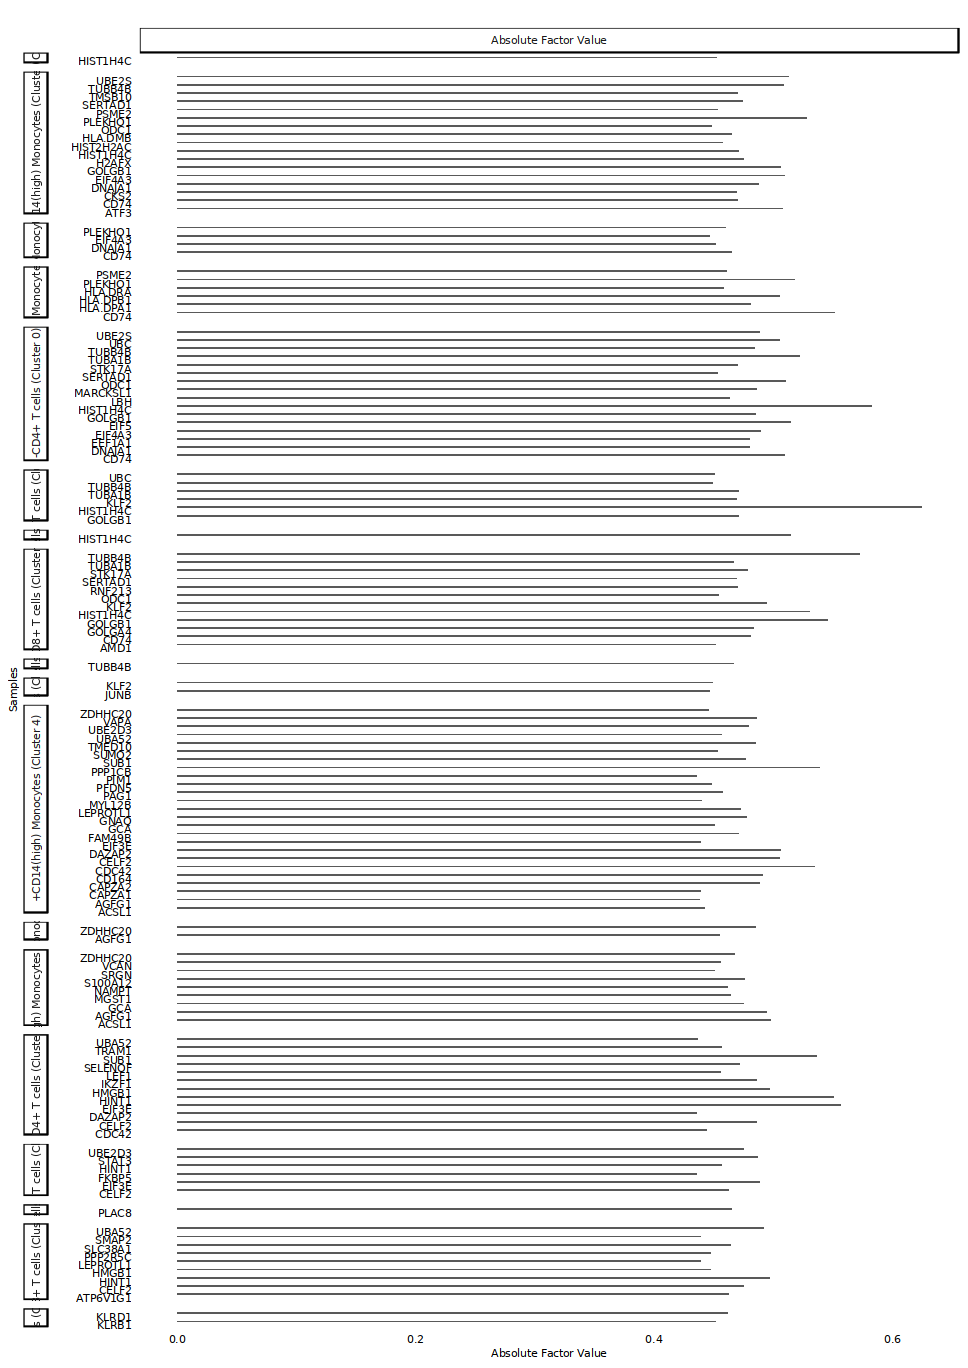

In [261]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
factor_value_all_bar

In [262]:
### Expression level heatmap

In [263]:
unique(heatmap_data$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [264]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
all_heatmap = ggplot(data = heatmap_data[(heatmap_data$variable == factor_var) & 
                                         (heatmap_data$fraction == top_frac) &
                                         (heatmap_data$classification %in% c('ccs', 'acs_w_o_infection')),], # TBD whether to filter on sample subset
                     mapping = aes(sample_id, gene,  fill= expression_value)) +
    scale_fill_gradient2(low="navy", high="red", midpoint = 0) + 
    geom_tile() + 
    xlabel_heatmap +
    ylabel_heatmap +
    plot_config_heatmap_supp  + theme(axis.text.x = element_blank()) + 
    facet_grid(facet  ~facet2, scales = 'free', space = 'free',  switch = "y") + theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.4, "cm"), strip.text.y.left = element_text(angle=0))+
    theme( axis.text.y = element_text( hjust = 1, vjust =1)) + 
    ggtitle(paste0('Normalized Expression Values of top ',as.numeric(top_frac) *100 *2, '% features'))

    

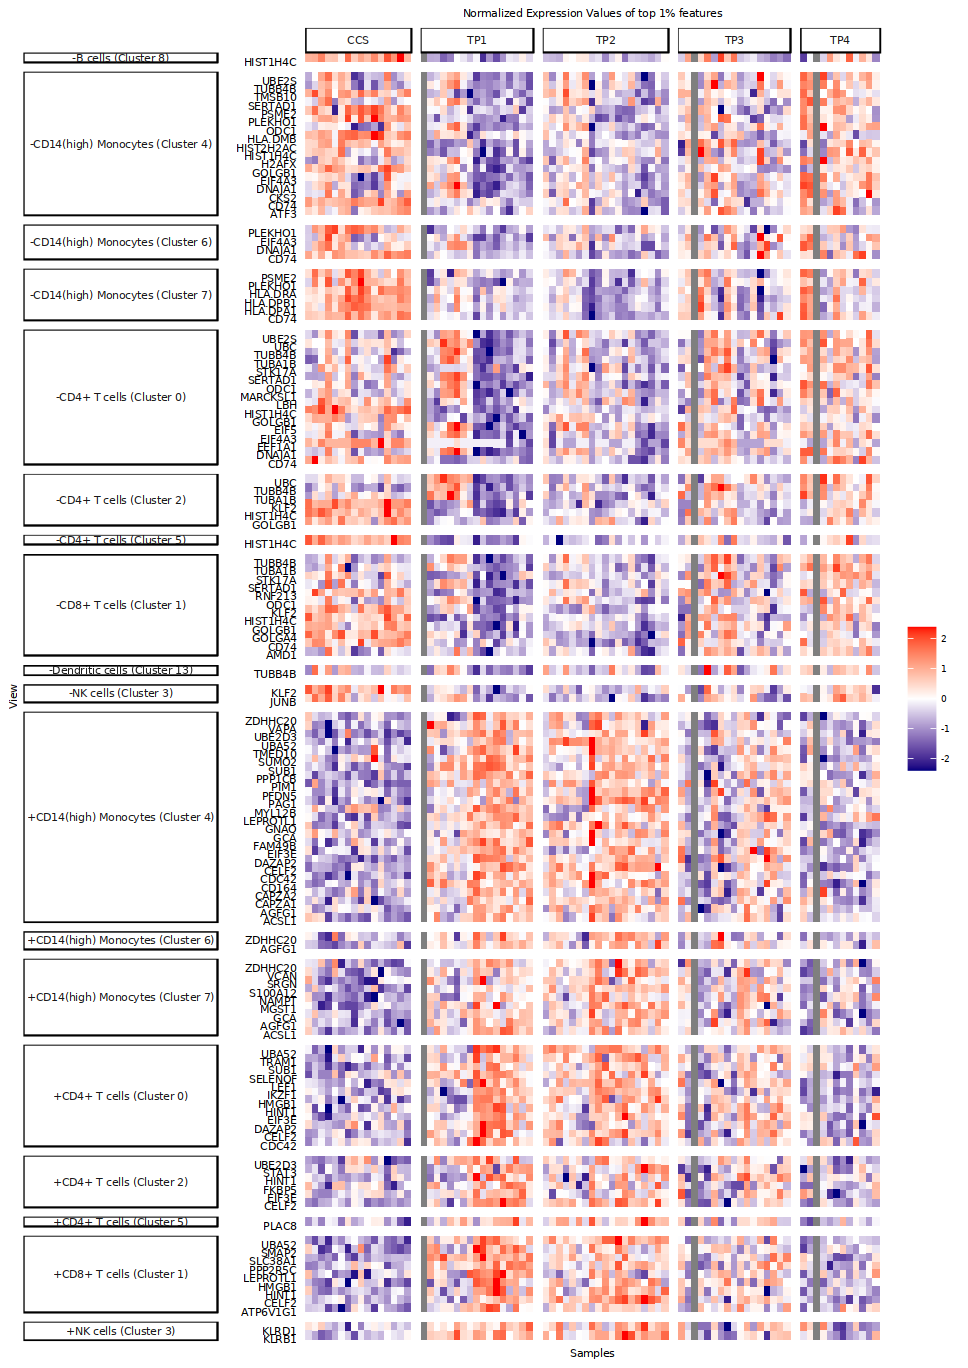

In [265]:
all_heatmap

In [266]:
### Combined factor plot and heatmap

In [267]:
legend =  get_legend(all_heatmap)

In [268]:
options(repr.plot.width=width_par, repr.plot.height=height_par)
combined = ggarrange(all_heatmap + theme(legend.position = 'none'),
         factor_value_all_bar + 
          theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), strip.background.y = element_blank() , strip.text.y = element_blank()),  
         nrow=1, widths = c(4,1), align = 'h')
combined = annotate_figure(combined, right = legend)

In [269]:
pdf(paste0('figures/Supplementary_Figures/', figure_name,factor_var, '_',  top_frac,  name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(combined)
dev.off()

png 
  2

In [270]:
### Supplementary Heatmaps)  - other with complete samples
# Configs: 

# SUPPLEMENTARY for Factor 1: variable = 'measurement2'
# SUPPLEMENTARY for Factor 4: variable = 'tp_outcome'